This code should do the following:<br>
XXX&nbsp;  1) Take an input temperature and spew back a model spectrum<br>
&nbsp; 2) Take two spectra and compute relevant flux contribution from each, given a filter profile<br>
&nbsp;     3) Compute the adjusted transit depth assuming unocculted spots with the properties above<br>
&nbsp;     4) Take a model transmission spectrum, adjust it according to two parameters:<br>
&nbsp; &nbsp;         Spot Teff (converted to contrast using 1-3)<br>
 &nbsp; &nbsp;        Spot coverage<br>
&nbsp;     5) Compare that model transmission spectrum to observed data inside emcee. <br>

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.timeseries import LombScargle
import astropy.units as u
import healpy as hp
from lightkurve import search_lightcurvefile
from emcee import EnsembleSampler
from multiprocessing import Pool
from corner import corner
from astropy.io import fits
from ldtk import LDPSetCreator, BoxcarFilter, TabulatedFilter
import emcee
from multiprocessing import Pool
from scipy import stats
import numpy.random as random
from scipy import optimize
import emcee
import corner
import random

In [7]:
def to_str(var):
    if type(var) is list:
        return str(var)[1:-1] # list
    if type(var) is np.ndarray:
        try:
            return str(list(var[0]))[1:-1] # numpy 1D array
        except TypeError:
            return str(list(var))[1:-1] # numpy sequence
    return str(var) # everything else

In [8]:
modelpath = '/Users/andrewmann/Dropbox/Radii/Models_CIFIST_Aug2013_filler.fits'
hdul = fits.open(modelpath)
hdul.info()
hdr = hdul[1].header
data = hdul[1].data

Filename: /Users/andrewmann/Dropbox/Radii/Models_CIFIST_Aug2013_filler.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     36   1R x 7C   [3760A, 30170102E, 302E, 302E, 302E, 302E, 302E]   


In [9]:
def getspec(data, inteff): ##  for now other parameters are fixed

    teff = np.squeeze(data['teff'])
    logg = np.squeeze(data['logg'])
    afe = np.squeeze(data['a_fe'])
    mh = np.squeeze(data['metal'])
    header = (data['header'])
    spectra = np.squeeze(data['spectrum'])
    lambda0 = 100
    nlambda = 99901
    dlambda = 1
    wave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)

    loc = np.where((teff == inteff) & (logg == 4.5) & (afe == 0) & (mh == 0))
    if np.size(loc) < 1:
        ## interpolate
        above = np.min(np.where((logg == 4.5) & (afe == 0) & (mh == 0) & (teff > inteff)))
        below = np.max(np.where((logg == 4.5) & (afe == 0) & (mh == 0) & (teff < inteff)))
        spec1 = np.squeeze(spectra[:,above])
        spec2 = np.squeeze(spectra[:,below])
        weight = (inteff-teff[below])/(teff[above]-teff[below])
        spec = (1.-weight)*spec1 + weight*spec2
        print(teff[above],teff[below],(1.-weight)*teff[above] + weight*teff[below])
    else:
        spec = np.squeeze(spectra[:,loc])
    #plt.plot(wave,spec)
    #plt.yscale('log')
    #plt.xscale('log')
    #plt.xlim(5000,50000)
    #ylimit = [np.min(spec[np.where((wave>5000) & (wave<50000))]),np.max(spec[np.where((wave>5000) & (wave<50000))])]
    #plt.ylim(ylimit[0],ylimit[1])
    #plt.show()
    return(spec)

5200.0
3800.0 3700.0 3750.0


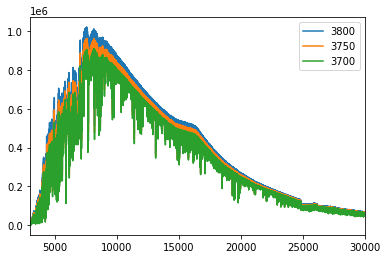

In [256]:
print(np.max(data['teff']))
lambda0 = 100
nlambda = 99901
dlambda = 1
wave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
spec1 = getspec(data,3800)
spec2 = getspec(data,3750)
spec3 = getspec(data,3700)
plt.plot(wave,spec1,label='3800')
plt.plot(wave,spec2,label='3750')
plt.plot(wave,spec3,label='3700')
plt.xlim(3000,30000)
plt.legend()
plt.show()

In [245]:
from scipy import interpolate

def convolve_filter(w,s,fw,ft):
    interpfunc = interpolate.interp1d(w, s, kind='linear')
    interpolflux = interpfunc(fw)
    flux = np.sum(ft*interpolflux)
    return(flux)

[ 6500.  6600.  6700.  6800.  6900.  7000.  7100.  7200.  7300.  7400.
  7500.  7600.  7700.  7800.  7900.  8000.  8100.  8200.  8300.  8400.
  8500.  8600.  8700.  8800.  8900.  9000.  9100.  9200.  9300.  9400.
  9500.  9600.  9700.  9800.  9900. 10000.]


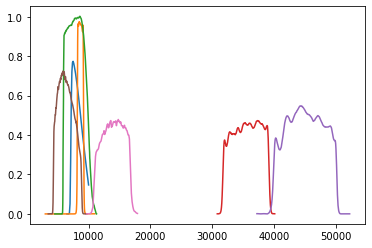

In [246]:
x,y = np.genfromtxt('filters/mearth.tsv', delimiter=';', unpack=True)
x*=10
plt.plot(x,y, label='MEarth')
mearth = TabulatedFilter('mearth', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/pstr-zs-avg.txt', unpack=True)
x*=10
plt.plot(x,y, label='zs')
zs = TabulatedFilter('zs', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/tess-response-function-v1.0.csv', unpack=True, comments='#', delimiter=',')
x*=10
plt.plot(x,y, label='tess')
tess = TabulatedFilter('tess', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/080924ch1trans_full.txt', unpack=True, comments='#', delimiter=',')
x*=10000
plt.plot(x,y, label='Sp1')
s1 = TabulatedFilter('S1', x[np.isfinite(y)], y[np.isfinite(y)])

x, y = np.genfromtxt('filters/080924ch2trans_full.txt', unpack=True, comments='#', delimiter=',')
x*=10000
plt.plot(x,y, label='Sp2')
s2 = TabulatedFilter('S2', x[np.isfinite(y)], y[np.isfinite(y)])

x,y = np.genfromtxt('filters/Kepler_Kepler.K.dat', unpack=True, comments='#', delimiter=',')
#x/=10
plt.plot(x,y, label='Kepler')
kepler = TabulatedFilter('Kepler', x[np.isfinite(y)], y[np.isfinite(y)])

x,y = np.genfromtxt('filters/HST_WFC3_IR.G141.dat', unpack=True, comments='#', delimiter=' ')
#x/=10
plt.plot(x,y, label='G141')
G141 = TabulatedFilter('G141', x[np.isfinite(y)], y[np.isfinite(y)])

## HST bands
b1 = [11108,11416,11709,11988,12257,12522,12791,13058,13321,13586,13860,14140,14425,14719,15027,15345,15682,16042]
b2 = [11416,11709,11988,12257,12522,12791,13058,13321,13586,13860,14140,14425,14719,15027,15345,15682,16042,16432]
b1 = [11108,11773.5,12439,13104.5,13770,14435.5,15101,15766.5]
b2 = [11773.5,12439,13104.5,13770,14435.5,15101,15766.5,16432]
nbins = 11
tmp = np.linspace(10880,16800,nbins+1)
b1 = np.round(tmp[0:nbins])
b2 = np.round(tmp[1:nbins+1])
b1_num = np.array(b1)/10
b2_num = np.array(b2)/10
HST_bands = []
hst_names = np.array(b1,dtype=str)
for i in range(0,np.size(b1)):
    str1 = (to_str(round(b1[i])))
    str2 = (to_str(round(b2[i])))
    hst_names[i] = str(str1)+'--'+str(str2)         
counter = 1
for i,j in zip(b1_num,b2_num):
    HST_bands.append(BoxcarFilter('HST'+str(counter),i,j))
    counter=counter+1

    
#print(HST_bands)
filters = HST_bands
filters.append(mearth)
filters.append(tess)
filters.append(s1)
filters.append(s2)
fnames = []
for i in range(0,np.size(filters)):
    fnames = np.append(names,filters[i].name)
## wl (double-u el) and tm
filters[0].__dict__.keys()
#filters[0].name
#names
#print(G141.tm)
inc = np.squeeze(np.where(fnames == 'mearth'))
print(filters[inc].wl)

In [253]:
## given depth (D), spot fraction (fS), and two spectra, compute the adjusted transit depth
def depth_adjust(filters,fnames,D,fS,wav,surf,spot,fname):
    star = surf*(1.-fS) + spot*fS
    outoftransit = star
    intransit = (surf-surf*(D/(1.-fS)))*(1.-fS) + spot*fS
    transit = (outoftransit-intransit)/outoftransit
    inc = np.squeeze(np.where(fnames == fname))
    wl = filters[inc].wl
    tm = filters[inc].tm
    #plt.plot(wav,transit)
    #plt.xlim(np.min(wl),np.max(wl))
    #plt.ylim(D*0.99,D*1.2)
    #plt.show()
    outoftransit_flux = convolve_filter(wav,outoftransit,wl,tm)
    intransit_flux = convolve_filter(wav,intransit,wl,tm)
    #measured = convolve_filter(wav,transit,wl,tm)
    #outoftransit_flux = convolve_filter(wav,outoftransit,wl,tm)
    #intransit_flux = convolve_filter(wav,intransit,wl,tm)
    print(outoftransit_flux/intransit_flux)
    newD = (outoftransit_flux-intransit_flux)/outoftransit_flux
    return(newD)

In [254]:
lambda0 = 100
nlambda = 99901
dlambda = 1
wave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
star = getspec(data,3800)
spot = getspec(data,3500)

fSpot = 0.2
Depth = 0.04
newD = depth_adjust(filters,fnames,Depth,fSpot,wave,star,spot,'tess')
print(newD)

# inc = np.squeeze(np.where(fnames == 'tess'))
# wl = filters[inc].wl
# tm = filters[inc].tm
# star2 = star*5
# t3 = convolve_filter(wave,spot,wl,tm)
# t2 = convolve_filter(wave,star,wl,tm)
# t1 = convolve_filter(wave,star2,wl,tm)
# print(t3,t2,t1)

# interpfunc1 = interpolate.interp1d(wave, star, kind='linear')
# interpfunc2 = interpolate.interp1d(wave, star2, kind='linear')
# match1 = interpfunc1(wl)
# match2 = interpfunc2(wl)
# plt.plot(wave,star)
# plt.plot(wl,match1)
# plt.plot(wl,match2)
# print(np.sum(tm*match1))
# print(np.sum(tm*match2))
# plt.xlim(5000,11000)
# plt.show()

1.0450657046577638
0.04312236489716386


In [ ]:
#define functions for MCMC
def ln_prior(theta):
    fS, Tspot, D = theta
    if fS < 0.0 or fS > 1 or Tspot < 2700 or Tspot > 3700 or D < 0 or D > 1:
        return -np.inf
    return 0

def ln_likelihood(theta, depth_obs, depth_err, filters, data):
    fS, Tspot, D = theta
    ## get the star spectrum
    star = getspec(data,3470)
    spot = getspec(data,Tspot)
    
    s_squared = np.square(depth_err)
    p = ((1. / np.sqrt(2 * np.pi * s_squared)) * np.exp(-np.square(depth_obs - depth_model) / (2 * s_squared)) 
    return output


def ln_posterior(theta, prim, sec):
    ln_p = ln_prior(theta)
    ln_like = ln_likelihood(theta, prim, sec)
    if not np.isfinite(ln_p):
        return -np.inf
    if not np.isfinite(ln_like):
        return -np.inf
    return ln_p + ln_like


In [ ]:
import emcee
nwalkers, ndim = 32, 5
nthreads = 12
logfrac_guess = np.log(0.42)
logadd_guess = np.log(0.01)
Pb_guess = 0.13
#Yb_guess = 0
#B_guess = 3.5
initial_guesses = [logfrac_guess, logadd_guess, Pb_guess, Yb_guess, B_guess]
initial_guesses = soln.x
print('if this is inf, we have a problem:')
print(ln_posterior(initial_guesses,prim,sec))
pos_0 = [initial_guesses*(1+0.01*np.random.randn(ndim)) for i in range(nwalkers)]

nsteps = 10000
burn = 1000
thin = 10

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(prim, sec), threads=nthreads)
sampler.run_mcmc(pos_0, nsteps,progress=True)

print('done')